# CLEAR-IT Figure 1

Here, we generate the plots shown in Figure 1.

First, let's load the required modules.

In [1]:
import sys
import clearit
import clearit.config
import re
import pandas as pd
import os
from pathlib import Path
from clearit import plot as plot
from clearit.io.extract_test_ids import extract_test_ids
from clearit.metrics.gather_mean_of_medians import gather_points_fast, gather_region_fast

## Figure 1d
d) shows the class-agnostic PR-AUC scores for linear evaluation of the encoders as they were optimized for the TNBC1-MxIF8 and TNBC2-MIBI8 datasets (both using the corresponding TME-A_ML6 labels).

Let's first define the path of the `tests` directory and the test IDs that correspond to the linear evaluations of the encoders.

In [ ]:
tests_dir = Path(clearit.config.OUTPUTS_DIR,"tests")
# path points to the test directory
# group defines the dataset (used for plotting purposes)
# config defines the encoder configuration (here used for putting everything in the correct x-column)
entries = [
    {"path": Path(tests_dir,"T0011"), "group": "TNBC1-MxIF8", "config": "base SimCLR"},
    {"path": Path(tests_dir,"T0008"), "group": "TNBC1-MxIF8", "config": "with optimized\nloss function"},
    {"path": Path(tests_dir,"T0030"), "group": "TNBC1-MxIF8", "config": "with optimized\naugmentations"},
    {"path": Path(tests_dir,"T0090"), "group": "TNBC1-MxIF8", "config": "with more pre-\ntraining data"},
    {"path": Path(tests_dir,"T0110"), "group": "TNBC2-MIBI8", "config": "base SimCLR"},
    {"path": Path(tests_dir,"T0105"), "group": "TNBC2-MIBI8", "config": "with optimized\nloss function"},
    {"path": Path(tests_dir,"T0174"), "group": "TNBC2-MIBI8", "config": "with optimized\naugmentations"},
    {"path": Path(tests_dir,"T0187"), "group": "TNBC2-MIBI8", "config": "with more pre-\ntraining data"},
]
# define the order of the configurations as they should appear in the plot
config_order = []
for e in entries:
    cfg = e['config']
    if cfg not in config_order:
        config_order.append(cfg)

Next, we gather the results from the defined test directories and compute the PR-AUC scores across 10 splits of the test set in the dataframe `df_d_prauc`.

In [ ]:
df_d_prauc = plot.gather_pr_auc(
    entries,
    chunks=10, # compute the scores across 10 splits of the data
    total=True # compute the class-agnostic PR-AUC
    )

Finally, we use the dataframe to generate the plot. The function also outputs `df_d_out` which contains the median values of the boxes.

,TNBC1-MxIF8,TNBC2-MIBI8
Configuration,,
base SimCLR,0.553465,0.831908
with optimized\nloss function,0.792189,0.941021
with optimized\naugmentations,0.847464,0.944181
with more pre-\ntraining data,0.861071,0.946126


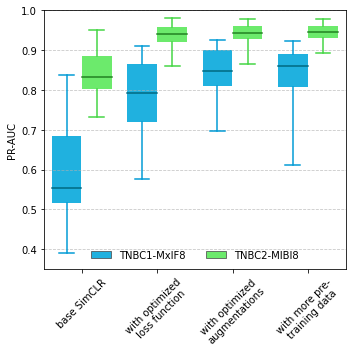

In [ ]:
# generate the plot
ax, df_d_out = plot.boxplot_performance(
    df_d_prauc,
    value_col="Value",
    show_total=False,
    show_mean_of_medians=False,
    order=config_order,
    figsize=(5,5),
    xtick_rotation=45,
    ylim=[0.35,1.00],
    ylabel="PR-AUC",
    legend_loc="lower center",
    legend_ncol=2,
)
# display the resulting dataframe
display(df_d_out)

## Figure 1e
e) shows the mean of median PR-AUC scores for linear evaluation of the TNBC1-MxIF8 encoders with TME-A_ML6 labels.

The plot shows the performance under "label reduction", i.e., as the number of patients included in the supervised training set for the linear classifier is reduced (from 47 patients/761 images to 1 patient/16 images (on average)). Three cases are displayed:
- Randomly sampling N patients from the full cohort (grey region)
- Only selecting patients whose images had the highest SNR ranking (light blue diamonds)
- Only selecting an equivalent amount of images with the highest SNR ranking (irrespective of patient) (dark blue circles)

Let's first define the path of the `tests` directory and the YAML recipe files containing information about the used linear classifiers and linear evaluations.

In [17]:
tests_dir = Path(clearit.config.OUTPUTS_DIR,"tests")
experiments_heads_dir = Path(clearit.config.EXPERIMENTS_DIR,"04_labelreduction2","tnbc1-mxif8","02_classifier","02_patientreduction")
experiments_tests_dir = Path(clearit.config.EXPERIMENTS_DIR,"04_labelreduction2","tnbc1-mxif8","03_linear-eval","02_patientreduction")

Next, we use a helper function `extract_test_ids` to extract the corresponding test IDs and prepare the dataframes `df_e_sampling`, `df_e_best_patients`, and `df_e_best_images`.

In [ ]:
# define a hardcoded mapping for number of images (in "best image" case) corresponding to number of patients
N_mapping = {
    47: 761,
    39: 659,
    30: 513,
    18: 325,
    12: 221,
    6: 112,
    3: 52,
    1: 21
}
# get list of test IDs for random sampling
test_list = extract_test_ids(
    Path(experiments_heads_dir,"01_tnbc1-mxif8_tme-a_ml6.yaml"),
    Path(experiments_tests_dir,"01_tnbc1-mxif8_tme-a_ml6.yaml"),
    "TNBC1-MxIF8",
    "TME-A_ML6",
    ['fold']
    )
entries = []
for test in test_list:
    entries.append({"path": Path(tests_dir,test["test_id"]), "group": "Random sampling", "config":f'{test["config"]}\n({N_mapping[test["config"]]})'})
# compute mean of median PR-AUC scores    
df_e_sampling = gather_region_fast(entries)
df_e_sampling.sort_values(by="Configuration",ascending=False,inplace=True)

# get list of test IDs for best patients
test_list = extract_test_ids(
    Path(experiments_heads_dir,"01_tnbc1-mxif8_tme-a_ml6.yaml"),
    Path(experiments_tests_dir,"01_tnbc1-mxif8_tme-a_ml6.yaml"),
    "TNBC1-MxIF8",
    "TME-A_ML6",
    ['best']
    )
entries = []
for test in test_list:
    entries.append({"path": Path(tests_dir,test["test_id"]), "group": "Patients with highest SNR ranking", "config":f'{test["config"]}\n({N_mapping[test["config"]]})'})
# compute mean of median PR-AUC scores    
df_e_best_patients = gather_points_fast(entries)
df_e_best_patients.sort_values(by="Configuration",ascending=False,inplace=True)

# get list of test IDs for best images
test_list = extract_test_ids(
    Path(experiments_heads_dir,"01_tnbc1-mxif8_tme-a_ml6.yaml"),
    Path(experiments_tests_dir,"01_tnbc1-mxif8_tme-a_ml6.yaml"),
    "TNBC1-MxIF8",
    "TME-A_ML6",
    ['best_images']
    )
entries = []
for test in test_list:
    entries.append({"path": Path(tests_dir,test["test_id"]), "group": "Images with highest SNR ranking\n(irrespective of patient)", "config":f'{test["config"]}\n({N_mapping[test["config"]]})'})
# compute mean of median PR-AUC scores    
df_e_best_images = gather_points_fast(entries)
df_e_best_images.sort_values(by="Configuration",ascending=False,inplace=True)

The `df_e_sampling` dataframe contains the columns "low" and "high", which specify the bounds of the shaded region. The other two dataframes contain a "mean_of_medians" column, which specifies the marker positions in the plot. We can use these dataframes to generate the plot directly. Below, we also merge the dataframes and display the values in a compact way.

,Number of patients (images),low,high,best patients,best images
0,47 (761),0.886196,0.887742,0.886788,0.884657
1,39 (659),0.879195,0.886641,0.883658,0.885101
2,30 (513),0.875895,0.883683,0.882876,0.884271
3,18 (325),0.865334,0.878964,0.877180,0.876407
4,12 (221),0.848104,0.873556,0.866336,0.867345
5,6 (112),0.811897,0.867620,0.858945,0.859610
6,3 (52),0.689284,0.827307,0.827683,0.835471
7,1 (21),0.314362,0.727806,0.704239,0.795319


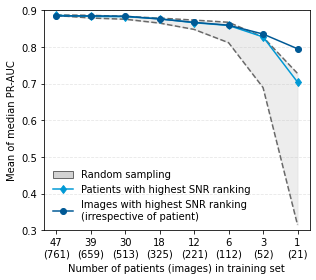

In [69]:
# define marker styles
marker_styles = { 
    "Patients with highest SNR ranking": "d",
    "Images with highest SNR ranking\n(irrespective of patient)": "o"
}
# define colors
color_map = { 
    "Patients with highest SNR ranking": "#0099d5", 
    "Images with highest SNR ranking\n(irrespective of patient)": "#005995"
}
# generate the plot
ax = plot.plot_region_and_lines(
    df_e_sampling,
    df_e_best_patients,
    df_e_best_images,
    xlabel="Number of patients (images) in training set",
    ylabel="Mean of median PR-AUC",
    marker_styles=marker_styles,
    color_map=color_map,
    legend_loc="lower left",
    categorical_x=True,
    figsize=(4.5,4),
    ylim=(0.3,0.9)
)
# combine the dataframes for display
# region: keep only low/high
reg = df_e_sampling[[ 'Configuration', 'low', 'high' ]]
# best patients: rename mean_of_medians → best patients
pts = (
    df_e_best_patients
      .set_index('Configuration')['mean_of_medians']
      .rename('best patients')
)
# best images similarly
imgs = (
    df_e_best_images
      .set_index('Configuration')['mean_of_medians']
      .rename('best images')
)

wide = (
    reg
      .set_index('Configuration')
      .join([pts, imgs])
      .reset_index()
      
)
wide["Configuration"] = wide["Configuration"].str.replace("\n"," ")
display(wide.rename(columns={"Configuration":"Number of patients (images)"}))

## Figure 1f
f) is similar to e) but for the TNBC2-MIBI8 dataset with TME-A_ML6 labels.

Since there is only one image per patient for this dataset, there is no distinction between the "best patients" and "best images" case. As such, only two cases are displayed:
- Randomly sampling N patients from the full cohort (grey region)
- Only selecting patients whose images had the highest SNR ranking (light green diamonds)

Let's first define the path of the `tests` directory and the YAML recipe files containing information about the used linear classifiers and linear evaluations.

In [70]:
tests_dir = Path(clearit.config.OUTPUTS_DIR,"tests")
experiments_heads_dir = Path(clearit.config.EXPERIMENTS_DIR,"04_labelreduction2","tnbc2-mibi8","02_classifier","02_patientreduction")
experiments_tests_dir = Path(clearit.config.EXPERIMENTS_DIR,"04_labelreduction2","tnbc2-mibi8","03_linear-eval","02_patientreduction")

Next, we use a helper function `extract_test_ids` to extract the corresponding test IDs and prepare the dataframes `df_f_sampling` and `df_f_best_patients`.

In [82]:
# get list of test IDs for random sampling
test_list = extract_test_ids(
    Path(experiments_heads_dir,"01_tnbc2-mibi8_tme-a_ml6.yaml"),
    Path(experiments_tests_dir,"01_tnbc2-mibi8_tme-a_ml6.yaml"),
    "TNBC2-MIBI/TNBC2-MIBI8",
    "TME-A_ML6",
    ['fold']
    )
entries = []
for test in test_list:
    entries.append({"path": Path(tests_dir,test["test_id"]), "group": "Random sampling", "config":f'{test["config"]}'})
# compute mean of median PR-AUC scores    
df_f_sampling = gather_region_fast(entries)
df_f_sampling.sort_values(by="Configuration",ascending=False,inplace=True)

# get list of test IDs for best patients
test_list = extract_test_ids(
    Path(experiments_heads_dir,"01_tnbc2-mibi8_tme-a_ml6.yaml"),
    Path(experiments_tests_dir,"01_tnbc2-mibi8_tme-a_ml6.yaml"),
    "TNBC2-MIBI/TNBC2-MIBI8",
    "TME-A_ML6",
    ['best']
    )
entries = []
for test in test_list:
    entries.append({"path": Path(tests_dir,test["test_id"]), "group": "Patients/images with highest SNR ranking", "config":f'{test["config"]}'})
# compute mean of median PR-AUC scores    
df_f_best_patients = gather_points_fast(entries)
df_f_best_patients.sort_values(by="Configuration",ascending=False,inplace=True)

The `df_f_sampling` dataframe contains the columns "low" and "high", which specify the bounds of the shaded region. `df_f_best_patients` contains a "mean_of_medians" column, which specifies the marker positions in the plot. We can use these dataframes to generate the plot directly. Below, we also merge the dataframes and display the values in a compact way.

,Number of images,low,high,best patients
0,47 (761),0.886196,0.887742,0.886788
1,39 (659),0.879195,0.886641,0.883658
2,30 (513),0.875895,0.883683,0.882876
3,18 (325),0.865334,0.878964,0.877180
4,12 (221),0.848104,0.873556,0.866336
5,6 (112),0.811897,0.867620,0.858945
6,3 (52),0.689284,0.827307,0.827683
7,1 (21),0.314362,0.727806,0.704239


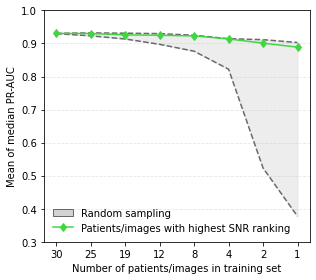

In [83]:
# define marker styles
marker_styles = { 
    "Patients/images with highest SNR ranking": "d",
}
# define colors
color_map = { 
    "Patients/images with highest SNR ranking": "#42d542", 
}
# generate the plot
ax = plot.plot_region_and_lines(
    df_f_sampling,
    df_f_best_patients,
    xlabel="Number of patients/images in training set",
    ylabel="Mean of median PR-AUC",
    marker_styles=marker_styles,
    color_map=color_map,
    legend_loc="lower left",
    categorical_x=True,
    figsize=(4.5,4),
    ylim=(0.3,1.0)
)
# combine the dataframes for display
# region: keep only low/high
reg = df_e_sampling[[ 'Configuration', 'low', 'high' ]]
# best patients: rename mean_of_medians → best patients
pts = (
    df_e_best_patients
      .set_index('Configuration')['mean_of_medians']
      .rename('best patients')
)

wide = (
    reg
      .set_index('Configuration')
      .join([pts])
      .reset_index()
      
)
wide["Configuration"] = wide["Configuration"].str.replace("\n"," ")
display(wide.rename(columns={"Configuration":"Number of images"}))

,CK+,CD3+,CD8+,CD20+,CD56+,CD68+,total,mean_of_medians
Configuration,,,,,,,,
9,0.843096,0.657501,0.818969,0.905513,0.608551,0.719604,0.774140,0.758873
4,0.855566,0.736121,0.850447,0.903613,0.594966,0.724030,0.792189,0.777457
8,0.855566,0.736121,0.850447,0.903613,0.594966,0.724030,0.792189,0.777457
12,0.772818,0.486122,0.529138,0.698140,0.357064,0.519800,0.527991,0.560514
13,0.787783,0.497112,0.514572,0.706786,0.399986,0.517396,0.520748,0.570606
14,0.709883,0.711272,0.809350,0.878463,0.554322,0.736417,0.739061,0.733284
15,0.817402,0.645334,0.699376,0.833466,0.456281,0.645889,0.683146,0.682958
16,0.810946,0.547914,0.627481,0.787566,0.432403,0.593275,0.614663,0.633264


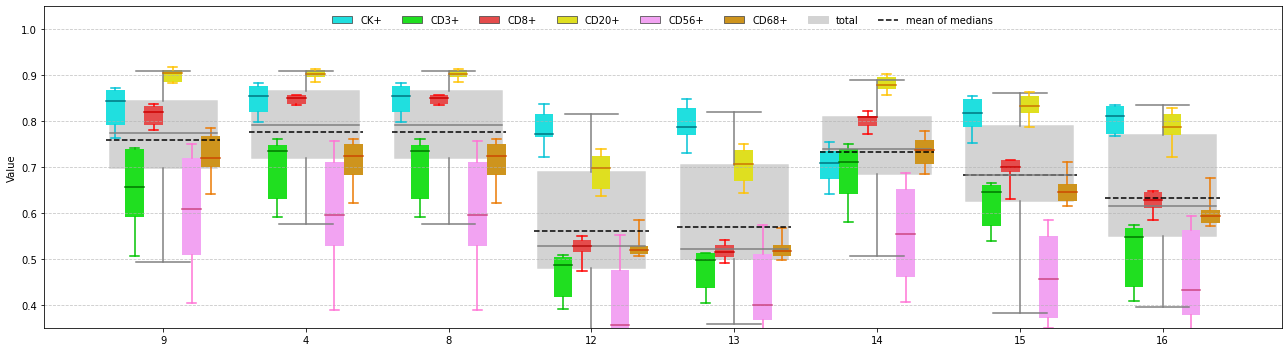

In [ ]:
ax, df_d_out = plot.boxplot_performance(
    df_d_prauc,
    value_col="Value",
    show_mean_of_medians=True,
    order=config_order,
    figsize=(18,5),
    xtick_rotation=0,
    ylim=[0.35,1.05],
    legend_loc="upper center",
    legend_ncol=8,
)
display(df_d_out)

In [5]:
df = plot.gather_pr_auc(entries,chunks=10,total=True)

In [ ]:
df_d_prauc = plot.gather_pr_auc(
    entries,
    chunks=10,
    class_labels=["CK+","CD3+","CD8+","CD20+","CD56+","CD68+"]
    )

,Configuration,Group,Value
0,base SimCLR,TNBC1-MxIF,0.844144
1,base SimCLR,TNBC1-MxIF,0.516755
2,base SimCLR,TNBC1-MxIF,0.503108
3,base SimCLR,TNBC1-MxIF,0.625585
4,base SimCLR,TNBC1-MxIF,0.427165
...,...,...,...
475,with more pre-\ntraining data,TNBC2-MIBI,0.944043
476,with more pre-\ntraining data,TNBC2-MIBI,0.927279
477,with more pre-\ntraining data,TNBC2-MIBI,0.930765
478,with more pre-\ntraining data,TNBC2-MIBI,0.945754


,TNBC1-MxIF,TNBC2-MIBI
Configuration,,
base SimCLR,0.553465,0.831908
with optimized\nloss function,0.792189,0.941021
with optimized\naugmentations,0.847464,0.944181
with more pre-\ntraining data,0.861071,0.946126


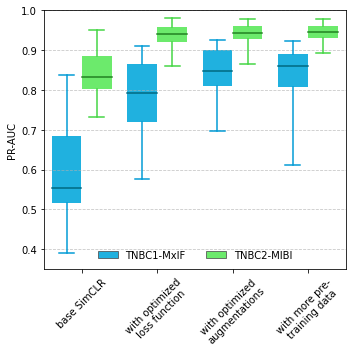

In [12]:
ax, df_out = plot.boxplot_performance(
    df,
    value_col="Value",
    show_total=False,
    show_mean_of_medians=False,
    order=config_order,
    figsize=(5,5),
    xtick_rotation=45,
    ylim=[0.35,1.00],
    ylabel="PR-AUC",
    legend_loc="lower center",
    legend_ncol=2,
)
display(df_out)

In [4]:
list_encoderdict_paths_temp = io_util.get_encoderdict_paths(status=1)
list_model_paths = []
list_names = []
prefix = "samestep_N_cell"
pattern = rf"{re.escape(prefix)}(\d+)"
for encoderdict_path in list_encoderdict_paths_temp:
    if "round3_" not in encoderdict_path: continue
    if "samestep" not in encoderdict_path: continue
    list_model_paths.append(os.path.dirname(encoderdict_path))
    match = re.search(pattern, encoderdict_path)
    number_str = match.group(1)
    a = int(number_str)
    list_names.append(a)
list_model_paths = [
    "../../../ver004/models/ntxent-round1_thresh00_tau0100_hardcore_curran/",
    "../../../ver004/models/ntxent-round1_B0256_thresh00_tau0005_festive_kilby",
    "../../../ver004/models/ntxent-round2_zoomfactor_min075_zoomfactor_max150_nostalgic_mclean/",
    #"./models/ntxent-round2b_bestzoom_contrast100_gaussian_blur06_clever_poincare/",
    #"./models/ntxent-round3_same-epoch_N_cell512000_agitated_goldstine/"
    "../../../ver004/models/ntxent-round3_same-epoch_N_cell512000_fixed/"
]
list_names = [
    "base SimCLR",
    "+ NT-Xent temperature",
    "+ augmentations",
    "10x pre-training size"
]

In [6]:
test_name = "hammerl-tmea"

list_sigmoids = []
list_targets = []
list_df_indices = []
list_xlabels = list_names
sigmoid_target_paths = [
    f"{model_path}/head_hammerl-tmea/test_{test_name}_best_prauc/test_sigmoids_targets.npz" for model_path in list_model_paths
]
list_sigmoids, list_targets = plot_util.load_sigmoids_targets_from_paths(sigmoid_target_paths)

list_classifier_metrics_dict, precision_baselines = plot_util.get_list_classifier_metrics_dict(list_sigmoids,
                                                                                               list_targets,
                                                                                               list_names,
                                                                                               list_xlabels,
                                                                                               split=10)
plot, df = plot_util.auc_boxplot(
    list_classifier_metrics_dict,
    #xlabel="Dataset size (cells)", 
    xlabel_order=list_names,
    xtick_labels=["base SimCLR","with optimized\nloss function","with optimized\naugmentations","with 10x pre-\ntraining data"],
    #title=f"Performance with varying encoder optimizations",
    figsize=(3.2,4),
    yticks=[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    ytick_labels=["0.4","","0.6","","0.8","","1.0"],
    xtick_label_rotation=45,
    xtick_label_ha="right",
    ylim=[0.35,1.0],
    font_size=8,
    show_legend=False,
    legend_rows=2
)
#plot.savefig("./results/results_optimization.svg")
#plot.show()
#df

AttributeError: module 'clearit.plot' has no attribute 'load_sigmoids_targets_from_paths'

In [ ]:
tests_dir = Path(clearit.config.OUTPUTS_DIR,"tests")
entries = [
    {"path": Path(tests_dir,"T0011"), "group": "TNBC1-MxIF", "config": "base SimCLR"},
    {"path": Path(tests_dir,"T0008"), "group": "TNBC1-MxIF", "config": "with optimized\nloss function"},
    {"path": Path(tests_dir,"T0030"), "group": "TNBC1-MxIF", "config": "with optimized\naugmentations"},
    {"path": Path(tests_dir,"T0090"), "group": "TNBC1-MxIF", "config": "with more pre-\ntraining data"},
    {"path": Path(tests_dir,"T0110"), "group": "TNBC2-MIBI", "config": "base SimCLR"},
    {"path": Path(tests_dir,"T0105"), "group": "TNBC2-MIBI", "config": "with optimized\nloss function"},
    {"path": Path(tests_dir,"T0174"), "group": "TNBC2-MIBI", "config": "with optimized\naugmentations"},
    {"path": Path(tests_dir,"T0187"), "group": "TNBC2-MIBI", "config": "with more pre-\ntraining data"},
]

<AxesSubplot:xlabel='Number of patients in training set', ylabel='Mean of median PR-AUC'>

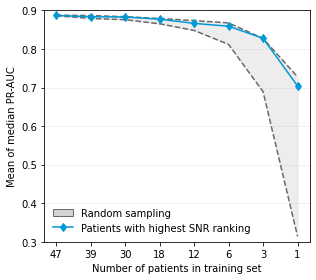

In [7]:
df_sampling

,Configuration,Group,low,high
7,47,Patients with highest SNR ranking,0.886196,0.887742
6,39,Patients with highest SNR ranking,0.879195,0.886641
5,30,Patients with highest SNR ranking,0.875895,0.883683
4,18,Patients with highest SNR ranking,0.865334,0.878964
3,12,Patients with highest SNR ranking,0.848104,0.873556
2,6,Patients with highest SNR ranking,0.811897,0.867620
1,3,Patients with highest SNR ranking,0.689284,0.827307
0,1,Patients with highest SNR ranking,0.314362,0.727806


In [21]:
ddf = gather_points_fast(entries)

In [22]:
ddf

,Configuration,Group,mean_of_medians
0,1,Patients with highest SNR ranking,0.704239
1,3,Patients with highest SNR ranking,0.827683
2,6,Patients with highest SNR ranking,0.858945
3,12,Patients with highest SNR ranking,0.866336
4,18,Patients with highest SNR ranking,0.877180
5,30,Patients with highest SNR ranking,0.882876
6,39,Patients with highest SNR ranking,0.883658
7,47,Patients with highest SNR ranking,0.886788


,Configuration,Group,mean_of_medians
0,1,Patients with highest SNR ranking,0.704239
1,3,Patients with highest SNR ranking,0.827683
2,6,Patients with highest SNR ranking,0.858945
3,12,Patients with highest SNR ranking,0.866336
4,18,Patients with highest SNR ranking,0.877180
5,30,Patients with highest SNR ranking,0.882876
6,39,Patients with highest SNR ranking,0.883658
7,47,Patients with highest SNR ranking,0.886788
